Training an ML Model on Chest X-Ray Images

In [36]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import sklearn.metrics
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import subprocess
import io
import glob
import scipy.misc
import numpy as np
import pandas as pd
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
import shutil
from tensorflow import keras
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras import Model
import matplotlib
from tensorflow.keras.optimizers import RMSprop
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.image as mpimg

Initial Setup
- Downloading the dataset from the following github repository

In [5]:
LEARING_RATE = 0.0001
repo_url = 'https://github.com/adleberg/medical-ai'
IMAGE_HEIGHT, IMAGE_WIDTH = 256, 256

# Download the data.
repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))
!git clone {repo_url} --quiet
%cd -q {repo_dir_path}
!git pull -q

/Users/pranaybhatt/Development/Medical Image AI model/env/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


We will be training the model to look for cardiomegaly within the chest x-ray images

In [7]:
finding = "Cardiomegaly"
df = pd.read_csv("./labels.csv")
df.head()

,filename,height,width,label,xmin,ymin,xmax,ymax,view
0,00013118_008.jpg,2992,2991,Atelectasis,225.0,547.0,311.0,626.0,PA
1,00014716_007.jpg,3056,2544,Atelectasis,686.0,131.0,871.0,444.0,AP
2,00029817_009.jpg,3056,2544,Atelectasis,221.0,317.0,376.0,533.0,AP
3,00014687_001.jpg,2500,2048,Atelectasis,726.0,494.0,867.0,549.0,AP
4,00017877_001.jpg,2500,2048,Atelectasis,660.0,569.0,860.0,647.0,AP


In [9]:
positives = df.loc[df["label"] == finding]
negatives = df.loc[df["label"] == "No Finding"]
n = len(positives)
print("Number of positive cases: {}".format(n))

Number of positive cases: 146


80% of the data will be used for training and 20% will be used for testing

In [10]:
TRAIN_RATIO = 0.8
TEST_RATIO = 0.2
TRAIN_N = int(n * TRAIN_RATIO)
TEST_N = int(n * TEST_RATIO)
print(TRAIN_N, TEST_N)

116 29


In [11]:
train_labels = pd.concat([positives.iloc[:TRAIN_N], negatives.iloc[:TRAIN_N]])
test_labels = pd.concat([positives.iloc[TRAIN_N:n], negatives.iloc[TRAIN_N:n]])

Preparing the data by sorting the images into two folders, one for negative cases and one for positive cases

In [13]:
root_dir = "./images/"
os.makedirs(root_dir + finding + "/test/positive", exist_ok=True)
os.makedirs(root_dir + finding + "/test/negative", exist_ok=True)
os.makedirs(root_dir + finding + "/train/positive", exist_ok=True)
os.makedirs(root_dir + finding + "/train/negative", exist_ok=True)

In [15]:
for idx, image in positives[:TRAIN_N].iterrows():
    source = root_dir + image["filename"]
    dst = root_dir + finding + "/train/positive/" + image["filename"]
    shutil.copyfile(source, dst)
    
for idx, image in positives[TRAIN_N:].iterrows():
    source = root_dir + image["filename"]
    dst = root_dir + finding + "/test/positive/" + image["filename"]
    shutil.copyfile(source, dst)

for idx, image in negatives[:TRAIN_N].iterrows():
    source = root_dir + image["filename"]
    dst = root_dir + finding + "/train/negative/" + image["filename"]
    shutil.copyfile(source, dst)
    
for idx, image in negatives[TRAIN_N:].iterrows():
    source = root_dir + image["filename"]
    dst = root_dir + finding + "/test/negative/" + image["filename"]
    shutil.copyfile(source, dst)

In [16]:
positive_imgs, negative_imgs = [], []
def load_image_into_numpy_array(image):
    image = image.convert('RGB')
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

for idx, row in positives[:6].iterrows():
    image_path = root_dir + row["filename"]
    image = Image.open(image_path).resize((IMAGE_HEIGHT, IMAGE_WIDTH))
    positive_imgs.append(load_image_into_numpy_array(image))
    
for idx, row in negatives[:6].iterrows():
    image_path = root_dir + row["filename"]
    image = Image.open(image_path).resize((IMAGE_HEIGHT, IMAGE_WIDTH))
    negative_imgs.append(load_image_into_numpy_array(image))

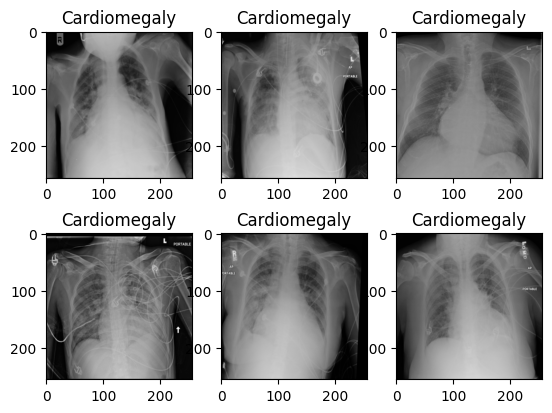

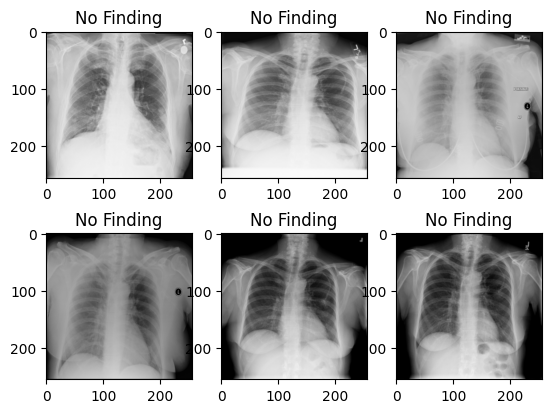

In [17]:
for idx, img in enumerate(positive_imgs):
    plt.subplot(2,3,idx+1)
    plt.title(finding)
    plt.imshow(positive_imgs[idx])
plt.show()

for idx, img in enumerate(negative_imgs):
    plt.subplot(2,3,idx+1)
    plt.title("No Finding")
    plt.imshow(negative_imgs[idx])
plt.show()

Training the AI Model using Tensorflow

In [19]:
pre_trained_model = InceptionV3(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, weights='imagenet')

for layer in pre_trained_model.layers:
    layer.trainable = False

last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [23]:
base_dir = './images/'
train_dir = os.path.join(base_dir, finding, 'train')
test_dir = os.path.join(base_dir, finding, 'test')

train_pos_dir = os.path.join(train_dir, 'positive')
train_neg_dir = os.path.join(train_dir, 'negative')
test_pos_dir = os.path.join(test_dir, 'positive')
test_neg_dir = os.path.join(test_dir, 'negative')


In [21]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False,
)

val_datagen = ImageDataGenerator(rescale=1./255)

In [24]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=1,
    class_mode='binary'
)

test_generator = val_datagen.flow_from_directory(
    test_dir,
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=1,
    class_mode='binary'
)

train_steps = len(os.listdir(train_pos_dir)) * 2
test_steps = len(os.listdir(test_pos_dir)) * 2

Found 232 images belonging to 2 classes.
Found 894 images belonging to 2 classes.


Running the model

In [26]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=20,
    validation_data=test_generator,
    validation_steps=test_steps,
    verbose=2
)

Epoch 1/20
232/232 - 48s - loss: 9.8897 - acc: 0.5733 - val_loss: 6.8178 - val_acc: 0.2167 - 48s/epoch - 207ms/step
Epoch 2/20
232/232 - 48s - loss: 1.6630 - acc: 0.7026 - val_loss: 5.1515 - val_acc: 0.1333 - 48s/epoch - 206ms/step
Epoch 3/20
232/232 - 48s - loss: 0.8855 - acc: 0.7069 - val_loss: 0.9853 - val_acc: 0.4500 - 48s/epoch - 207ms/step
Epoch 4/20
232/232 - 48s - loss: 0.5758 - acc: 0.7069 - val_loss: 0.8806 - val_acc: 0.6167 - 48s/epoch - 206ms/step
Epoch 5/20
232/232 - 48s - loss: 0.4968 - acc: 0.7457 - val_loss: 0.7827 - val_acc: 0.4833 - 48s/epoch - 206ms/step
Epoch 6/20
232/232 - 48s - loss: 0.5548 - acc: 0.7284 - val_loss: 1.1009 - val_acc: 0.3167 - 48s/epoch - 206ms/step
Epoch 7/20
232/232 - 48s - loss: 0.4704 - acc: 0.7716 - val_loss: 0.8069 - val_acc: 0.6500 - 48s/epoch - 207ms/step
Epoch 8/20
232/232 - 49s - loss: 0.5046 - acc: 0.7500 - val_loss: 0.6261 - val_acc: 0.6833 - 49s/epoch - 211ms/step
Epoch 9/20
232/232 - 50s - loss: 0.4851 - acc: 0.7888 - val_loss: 0.7453

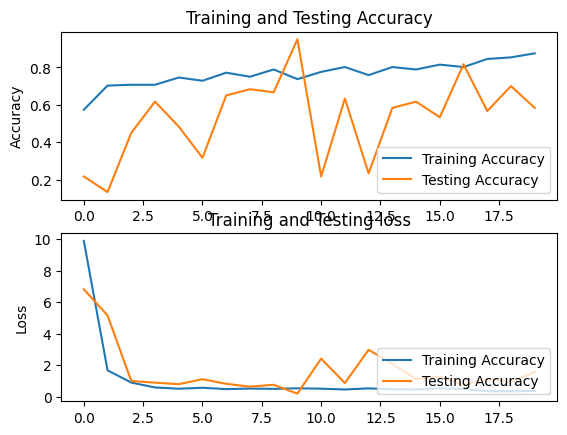

In [30]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.subplot(2,1,1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Testing Accuracy')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy')
plt.legend(loc='lower right')

plt.subplot(2,1,2)
plt.plot(epochs, loss, label='Training Accuracy')
plt.plot(epochs, val_loss, label='Testing Accuracy')
plt.ylabel('Loss')
plt.title('Training and Testing loss')
plt.legend(loc='lower right')

Evaluating the performance

In [59]:
# def predict_image(filename):
#     image = Image.open(filename).resize((IMAGE_WIDTH, IMAGE_HEIGHT))
#     image_np = load_image_into_numpy_array(image)
#     exp = np.true_divide(image_np, 255.0)
#     exp = np.stack(exp, axis=-1)
#     expanded = np.expand_dims(exp, axis=0)
#     return model.predict(expanded)[0][0]

def predict_image(filename):
    img = keras.preprocessing.image.load_img(filename, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch

    predictions = model.predict(img_array)
    score = predictions[0]
    return score

def show_df_row(row):
    filename = "images/" + row['filename']
    img = keras.preprocessing.image.load_img(filename, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT), color_mode='rgb')
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch

    pred = model.predict(img_array)[0][0]
    guess = "neg"
    if pred > 0.5:
        guess = "pos"
    print(f"filename: {filename}")
    print(f"actual: {row['label']}")
    print(f"predicted: {guess} ({pred})")
    plt.imshow(img)
    plt.show()
    

In [38]:
results = []
for image in os.listdir(test_neg_dir):
    filename = test_neg_dir + "/" + image
    confidence = predict_image(filename)
    guess = "pos" if confidence > 0.5 else "neg"
    results.append([filename, image, "neg", guess, confidence])
    
for image in os.listdir(test_pos_dir):
    filename = test_pos_dir + "/" + image
    confidence = predict_image(filename)
    guess = "pos" if confidence > 0.5 else "neg"
    results.append([filename, image, "pos", guess, confidence])
    
sorted_results = sorted(results, key=lambda x: x[4], reverse=True)
df = pd.DataFrame(data=sorted_results, columns=["filepath", "filename", "label", "guess", "confidence"])

1/1 [==============================] - 0s 76ms/step


In [50]:
df.head()

,filepath,filename,label,guess,confidence
0,./images/Cardiomegaly/test/negative/00000181_0...,00000181_065.jpg,neg,pos,[1.0]
1,./images/Cardiomegaly/test/negative/00000121_0...,00000121_005.jpg,neg,pos,[1.0]
2,./images/Cardiomegaly/test/negative/00000402_0...,00000402_007.jpg,neg,pos,[1.0]
3,./images/Cardiomegaly/test/negative/00000459_0...,00000459_013.jpg,neg,neg,[0.019967169]
4,./images/Cardiomegaly/test/negative/00000129_0...,00000129_000.jpg,neg,neg,[0.0019079898]


1/1 [==============================] - 0s 70ms/step
filename: images/00000283_000.jpg
actual: neg
predicted: neg (0.0)


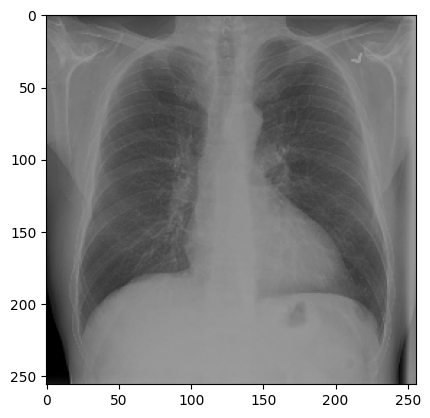

In [99]:
n = random.randint(0, len(df)-1)
show_df_row(df.iloc[n])
# import os

# filename = "images/00029906_000.jpg"
# if os.path.exists(filename):
#     print("File exists")
# else:
#     print("File does not exist")